In [1]:
from langgraph.graph import StateGraph, START,END
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate 
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_ollama import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from pydantic import BaseModel,Field
from typing import TypedDict,Literal,List
from langchain_core.documents import Document
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")


In [4]:
llm=ChatGroq(model="llama-3.3-70b-versatile",groq_api_key=GROQ_API_KEY)

In [5]:
docs = (
  PyPDFLoader("documents/ElectronAI_Company_Vision_and_Policies.pdf").load() +
  PyPDFLoader("documents/ElectronAI_Employee_Perks_and_Benefits.pdf").load() +
  PyPDFLoader("documents/ElectronAI_Salary_Structure_and_Compensation_Policy.pdf").load()
)

splitter = RecursiveCharacterTextSplitter(
    chunk_size=750,
    chunk_overlap=100
)
chunks = splitter.split_documents(docs)

In [6]:
chunks

[Document(metadata={'producer': 'ReportLab PDF Library - www.reportlab.com', 'creator': '(unspecified)', 'creationdate': '2026-02-25T08:37:46+00:00', 'author': '(anonymous)', 'keywords': '', 'moddate': '2026-02-25T08:37:46+00:00', 'subject': '(unspecified)', 'title': '(anonymous)', 'trapped': '/False', 'source': 'documents/ElectronAI_Company_Vision_and_Policies.pdf', 'total_pages': 2, 'page': 0, 'page_label': '1'}, page_content='ElectronAI - Company Vision & Policies\nAbout ElectronAI\nElectronAI is a next-generation artificial intelligence company focused on building adaptive, scalable,\nand enterprise-ready AI systems.\nThe company specializes in Retrieval-Augmented Generation (RAG), agentic workflows, and AI\ninfrastructure solutions for enterprises and startups.\nVision and Mission\nVision: To democratize advanced AI systems and make intelligent automation accessible across\nindustries.\nMission: To build reliable, safe, and high-performance AI platforms that empower organizations 

In [7]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")
vectorstore=FAISS.from_documents(chunks,embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k":4})

In [8]:
def retrieve_documents(query: str, k: int = 4) -> List[Document]:
    return retriever.invoke(query)

In [9]:
class AdaptiveState(TypedDict):
  question:str
  response:str
  strategy:Literal["standard","multi-retrieval","rewrite"]
  docs:List[Document]
  filtered_docs:List[Document]


In [10]:
class RouteQuery(BaseModel):
  strategy:Literal["standard","multi-retrieval","rewrite"]

In [11]:
class GradeDocuments(BaseModel):
  binary_score:Literal["yes","no"]

In [12]:
ROUTING_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     """You are a retrieval strategy expert.

Choose the best retrieval strategy:

1. standard → direct factual questions
2. multi_retrieval → comparison or analytical queries
3. rewrite → vague or ambiguous queries

Select minimal sufficient strategy."""),
    ("human", "{question}")
])

router_llm = llm.with_structured_output(RouteQuery)
router_chain = ROUTING_PROMPT | router_llm


In [13]:
REWRITE_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     """Rewrite unclear or underspecified questions to improve retrieval.
Preserve intent. Make it specific. Return only rewritten question."""),
    ("human", "{question}")
])

rewrite_chain = REWRITE_PROMPT | llm | StrOutputParser()

In [14]:
GRADE_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     """You are a document relevance evaluator.

Return 'yes' if document contains useful info.
Return 'no' if unrelated.
No explanations."""),
    ("human",
     "Question:\n{question}\n\nDocument:\n{document}")
])

grader_llm = llm.with_structured_output(GradeDocuments)
grade_chain = GRADE_PROMPT | grader_llm


In [15]:
ANSWER_PROMPT = ChatPromptTemplate.from_messages([
    ("system",
     """You are a grounded AI assistant.

Use only provided context.
If insufficient, say so.
Be structured and professional.
No hallucinations."""),
    ("human",
     "Context:\n{context}\n\nQuestion:\n{question}\n\nAnswer:")
])

answer_chain = ANSWER_PROMPT | llm | StrOutputParser()

In [16]:
def route_node(state: AdaptiveState):
    result = router_chain.invoke(
        {"question": state["question"]}
    )
    return {"strategy": result.strategy}


In [17]:
def rewrite_node(state:AdaptiveState):
  improved = rewrite_chain.invoke({"question":state["question"]})
  return {"question":improved}

In [18]:
def retrieval_node(state: AdaptiveState):
    query = state["question"]

    if state["strategy"] == "multi-retrieval":  
        docs1 = retrieve_documents(query, k=4)

        alt_query = (
            f"Detailed explanation of ElectronAI policies, "
            f"compensation structure, benefits, and governance "
            f"related to {query}"
        )

        docs2 = retrieve_documents(alt_query, k=4)

        combined = {doc.page_content: doc for doc in docs1 + docs2}
        docs = list(combined.values())

    else:
        docs = retrieve_documents(query, k=4)

    return {"docs": docs}

In [19]:
def grade_node(state: AdaptiveState):
    docs = state.get("docs")

    if not docs:
        print("No documents found before grading.")
        return {"filtered_docs": []}

    relevant_docs = []

    for doc in docs:
        score = grade_chain.invoke({
            "question": state["question"],
            "document": doc.page_content
        })

        if score.binary_score == "yes":
            relevant_docs.append(doc)

    return {"filtered_docs": relevant_docs}

In [20]:
def generate_node(state: AdaptiveState):
    if not state.get("filtered_docs"):
        return {"response": "No relevant documents found to answer the question."}

    context = "\n\n".join(doc.page_content for doc in state["filtered_docs"])
 
    response = answer_chain.invoke({
        "context": context,
        "question": state["question"]
    })

    return {"response": response}

In [21]:
def route_decision(state: AdaptiveState):
    if state["strategy"] == "rewrite":
        return "rewrite"
    return "retrieve"


def fallback_decision(state: AdaptiveState):
    if not state["filtered_docs"]:
        return "rewrite"
    return "generate"

In [22]:
workflow = StateGraph(AdaptiveState)

workflow.add_node("route", route_node)
workflow.add_node("rewrite", rewrite_node)
workflow.add_node("retrieve", retrieval_node)
workflow.add_node("grade", grade_node)
workflow.add_node("generate", generate_node)

workflow.set_entry_point("route")

workflow.add_conditional_edges(
    "route",
    route_decision,
    {
        "rewrite": "rewrite",
        "retrieve": "retrieve",
    },
)

workflow.add_edge("rewrite", "retrieve")
workflow.add_edge("retrieve", "grade")

workflow.add_conditional_edges(
    "grade",
    fallback_decision,
    {
        "rewrite": "rewrite",
        "generate": "generate",
    },
)

workflow.add_edge("generate", END)

graph = workflow.compile()

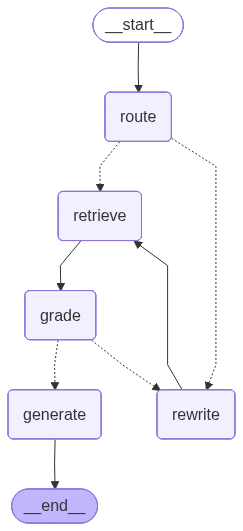

In [23]:
graph

In [ ]:
if __name__ == "__main__":
    result = graph.invoke(
        {"question": "What is the official leave policy at ElectronAI?"}
    )

    print("\nFinal Answer:\n")
    print(result["response"])